In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.impute import SimpleImputer

In [2]:
#chargement de la base de donnée
df = pd.read_excel('base_de_donnees_nettoyee.xlsx')

print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9774 entries, 0 to 9773
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   titre                   9770 non-null   object 
 1   Presse                  9380 non-null   float64
 2   Spectateurs             9774 non-null   float64
 3   durée                   9774 non-null   int64  
 4   Année de production     9774 non-null   int64  
 5   nombre nationalités     9769 non-null   float64
 6   prix                    9774 non-null   int64  
 7   nominations             9774 non-null   int64  
 8   commercialiser          9774 non-null   int64  
 9   Comédie                 9774 non-null   int64  
 10  Comédie dramatique      9774 non-null   int64  
 11  Drame                   9774 non-null   int64  
 12  Aventure                9774 non-null   int64  
 13  Animation               9774 non-null   int64  
 14  Famille                 9774 non-null   

In [3]:
# gerer les outliers des variables suivantes.
colone_a_verifier = ['durée', 'prix', 'nominations', 'log_Box Office France']
# Fonction pour retirer les outliers à l'aide de l'IQR
def retirer_outliers(df, colones):
    for colone in colones:
        # Calcul des quartiles Q1 (25%) et Q3 (75%)
        Q1 = df[colone].quantile(0.25)
        Q3 = df[colone].quantile(0.75)
        
        # Calcul de l'interquartile
        IQR = Q3 - Q1
        
        # Définir les bornes inférieure et supérieure
        borne_inférieure = Q1 - 1.5 * IQR
        borne_supérieure = Q3 + 1.5 * IQR
        if IQR!=0:
            # Appliquer le filtrage pour retirer les outliers
            df = df[(df[colone] >= borne_inférieure) & (df[colone] <= borne_supérieure)]
    
    return df

def winsorize(df,colone_a_verifier, borne_inferieur=5, borne_superieur=95):
    # Applique la transformation sur chaque colonne numérique
    for colone in colone_a_verifier:
        # Calculer les percentiles
        inferieur = np.percentile(df[colone], borne_inferieur)
        superieur = np.percentile(df[colone], borne_superieur)
        
        # Remplacer les valeurs inférieures au percentile inférieur
        df[colone] = np.where(df[colone] < inferieur, inferieur, df[colone])
        
        # Remplacer les valeurs supérieures au percentile supérieur
        df[colone] = np.where(df[colone] > superieur, superieur, df[colone])
    
    return df

# Appliquer la fonction pour enlever les outliers
#df_sans_outliers = retirer_outliers(df, colone_a_verifier) # on ne retire pas les outliers directemmetn sinon on perd trop d'infos, on opte pour une winsorisation 
df_sans_outliers = winsorize(df, colone_a_verifier) #on winsorize ces colones sinon on perd trop d'infos pres de20 % de la base de donnée. il serai taussi interessant d'introduirle champ log de budget mais le nombre de valeurs modifier est trop important pres de 60%

print (df_sans_outliers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9774 entries, 0 to 9773
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   titre                   9770 non-null   object 
 1   Presse                  9380 non-null   float64
 2   Spectateurs             9774 non-null   float64
 3   durée                   9774 non-null   float64
 4   Année de production     9774 non-null   int64  
 5   nombre nationalités     9769 non-null   float64
 6   prix                    9774 non-null   float64
 7   nominations             9774 non-null   float64
 8   commercialiser          9774 non-null   int64  
 9   Comédie                 9774 non-null   int64  
 10  Comédie dramatique      9774 non-null   int64  
 11  Drame                   9774 non-null   int64  
 12  Aventure                9774 non-null   int64  
 13  Animation               9774 non-null   int64  
 14  Famille                 9774 non-null   

In [4]:
#effectuer un lasso sur notre base de données pour selectioner les varibles d'interet

# Créer un objet imputer pour imputer les valeurs manquantes par la moyenne
variables_interets=[ 'Presse', 'Spectateurs', 'durée', 'Année de production', 'nombre nationalités', 'prix', 'nominations', 'commercialiser', 'Comédie', 'Comédie dramatique', 'Drame', 'Aventure', 'Animation', 'Famille', 'Thriller', 'Action', 'Péplum', 'Historique', 'Fantastique', 'Comédie musicale', 'Romance', 'Epouvante-horreur', 'Biopic', 'Musical', 'Science Fiction', 'Guerre', 'Policier', 'Espionnage', 'Western', 'Erotique', 'Arts Martiaux', 'Judiciaire', 'Expérimental', 'Bollywood', 'Évènement Sportif', 'Drama', 'Divers', 'Concert', 'Spectacle', 'Opéra', 'nombre_actrice', 'pressence_realisatrice', 'log_Budget', 'log_Box Office France']
imputer = SimpleImputer(strategy='mean')

# Appliquer l'imputation sur X
df_imputed =  pd.DataFrame(imputer.fit_transform(df_sans_outliers.drop(["titre"], axis=1)),columns=variables_interets)
#'Comédie', 'Comédie dramatique', 'Drame', 'Aventure', 'Animation', 'Famille', 'Thriller', 'Action', 'Péplum', 'Historique', 'Fantastique', 'Comédie musicale', 'Romance', 'Epouvante-horreur', 'Biopic', 'Musical', 'Science Fiction', 'Guerre', 'Policier', 'Espionnage', 'Western', 'Erotique', 'Arts Martiaux', 'Judiciaire', 'Expérimental', 'Bollywood', 'Évènement Sportif', 'Drama', 'Divers', 'Concert', 'Spectacle', 'Opéra'

# Séparer les variables_explicatives de la variable_cible
v_explicatives = df_imputed.drop(columns=["Spectateurs"])
v_cible = df_imputed["Spectateurs"]

# Séparer les données en un jeu d'entraînement et de test
v_explicatives_train, v_explicatives_test, v_cible_train, v_cible_test = train_test_split(v_explicatives, v_cible, test_size=0.2, random_state=42)

# Standardiser les données (important pour la régression Lasso)
variables_interets=[ 'Presse', 'durée', 'Année de production', 'nombre nationalités', 'prix', 'nominations', 'commercialiser', 'Comédie', 'Comédie dramatique', 'Drame', 'Aventure', 'Animation', 'Famille', 'Thriller', 'Action', 'Péplum', 'Historique', 'Fantastique', 'Comédie musicale', 'Romance', 'Epouvante-horreur', 'Biopic', 'Musical', 'Science Fiction', 'Guerre', 'Policier', 'Espionnage', 'Western', 'Erotique', 'Arts Martiaux', 'Judiciaire', 'Expérimental', 'Bollywood', 'Évènement Sportif', 'Drama', 'Divers', 'Concert', 'Spectacle', 'Opéra', 'nombre_actrice', 'pressence_realisatrice', 'log_Budget', 'log_Box Office France']
scaler = StandardScaler()
v_explicatives_train_scaled = pd.DataFrame(scaler.fit_transform(v_explicatives_train),columns=variables_interets)
v_explicatives_test_scaled = pd.DataFrame(scaler.transform(v_explicatives_test),columns=variables_interets)

# Liste des valeurs alpha à tester pour obtenir la meilleur regression en lasso
valeurs_alpha = np.array([0.0001,0.0002,0.0005,0.001,0.002,0.05,0.01,0.02,0.025,0.05,0.1,0.25,0.5,0.8,1.0])

# Créer le modèle Lasso
lasso = Lasso()

# Définir les paramètres à rechercher
param_grid = {'alpha': valeurs_alpha}

# Utiliser GridSearchCV pour trouver le meilleur alpha
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5)

# Entraîner le modèle avec GridSearchCV
grid_search.fit(v_explicatives_train_scaled, v_cible_train)

# Afficher le meilleur alpha trouvé
best_alpha=grid_search.best_params_
print("Meilleur alpha : ", best_alpha)

Meilleur alpha :  {'alpha': 0.002}


In [5]:
# Prédictions sur les données de test avec le meilleur alpha
v_cible_pred = grid_search.predict(v_explicatives_test_scaled)

# Évaluation de la robustéce du modèle
mse = mean_squared_error(v_cible_test, v_cible_pred)
r2 = r2_score(v_cible_test, v_cible_pred)

# Afficher les résultats
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 0.2705220527778543
R² Score: 0.39260300275823123


In [6]:
# Visualiser les coefficients associer a cette alpha optimal
meilleur_lasso = grid_search.best_estimator_ # recuperer le lasso associer au meilleur alpha
coefficients = meilleur_lasso.coef_# recuperer les coeficients
coef = pd.DataFrame({
    "variables": v_explicatives_test_scaled.columns,  # Noms des colonnes
    "Coefficients": coefficients  # Valeurs des coefficients
    })
coef=coef[coef["Coefficients"] != 0]
print(coef)

                 variables  Coefficients
0                   Presse      0.283017
1                    durée      0.126567
2      Année de production      0.093106
3      nombre nationalités     -0.011806
4                     prix      0.036564
5              nominations      0.029947
6           commercialiser     -0.019723
7                  Comédie     -0.049511
8       Comédie dramatique      0.026042
9                    Drame      0.101184
11               Animation      0.091075
12                 Famille      0.022216
13                Thriller      0.000529
14                  Action      0.021181
15                  Péplum     -0.006404
16              Historique      0.002706
17             Fantastique     -0.020381
18        Comédie musicale     -0.000310
19                 Romance      0.020724
20       Epouvante-horreur     -0.028572
21                  Biopic      0.028587
22                 Musical      0.012635
23         Science Fiction      0.002894
24              

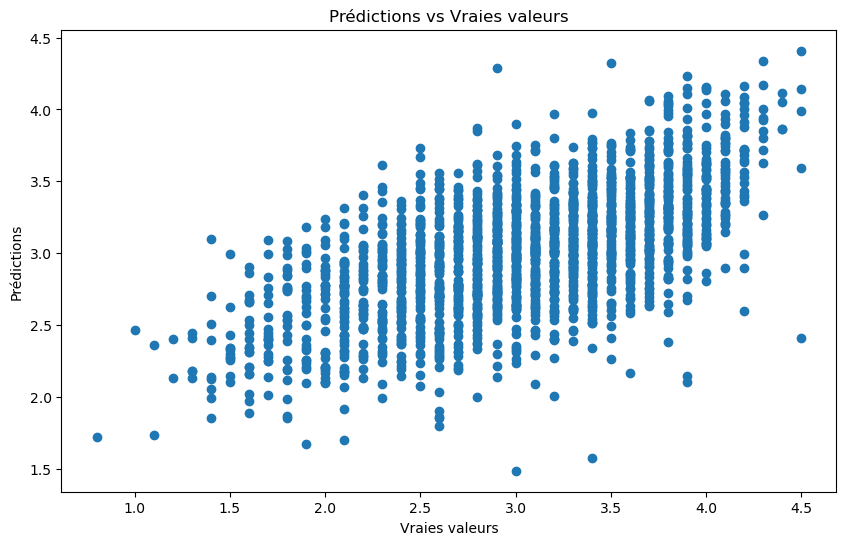

In [7]:
# Visualiser les prédictions par rapport aux vraies valeurs
plt.figure(figsize=(10, 6))
plt.scatter(v_cible_test, v_cible_pred)
plt.xlabel("Vraies valeurs")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Vraies valeurs")
plt.show()

In [8]:
# effectuer la regression linéaire sur les variables selectioner par le lasso

# selectionnenr les variables selectionner par le lasso
v_explicatives_test_cut=v_explicatives_test[coef["variables"]]
v_explicatives_train_cut=v_explicatives_train[coef["variables"]]

# Ajouter une constante (intercept) à X
v_explicatives_test_cut = sm.add_constant(v_explicatives_test_cut)  # Ajouter l'intercept à notre data frame de test
v_explicatives_train_cut = sm.add_constant(v_explicatives_train_cut)  # Ajouter l'intercept à notre data frame d'entrainnement

# Créer et entraîner le modèle OLS (Ordinary Least Squares)
model = sm.OLS(v_cible_train,v_explicatives_train_cut)  # OLS : Ordinaire Moindres Carrés (Ordinary Least Squares)
results = model.fit()

# Résumé des résultats
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Spectateurs   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     148.3
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        23:24:15   Log-Likelihood:                -5883.3
No. Observations:                7819   AIC:                         1.185e+04
Df Residuals:                    7778   BIC:                         1.213e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -26

In [9]:
#Faire des prédictions
y_pred = results.predict(v_explicatives_test_cut)

#Évaluer la performance de robustéce du modèle
mse = mean_squared_error(v_cible_test, y_pred)  # Erreur quadratique moyenne
r2 = r2_score(v_cible_test, y_pred)  # Coefficient de détermination R²

# Afficher les résultats
print(f"Mean Squared Error (MSE) : {mse}")
print(f"R² : {r2}")

Mean Squared Error (MSE) : 0.2715323464965377
R² : 0.39033461330620955


En conclusion, même si les coeficients , à l'exeption de ceux de genre, sont significatifs la faible valeur du R2 ,autour de 0.4,
nous indique que notre regression n'est pas robuste. Peut étre que si on avait moins de valeurs manquantes
(surtout concernant le budget), et l'acces à d'autres variables, comme à la qualités de l'image, ou le nombre d'image par
secondes moyen,   notre resultat serait meilleur. 
Ou peut etre que le probléme repose sur le modéle chosit et qu'un modéle de classification aurait été plus adapté.
Neamoins dans l'état actuel notre regression est imparfaite